## Load Data

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import time

#  Import and read the data
application_df = pd.read_csv("../Resources/IMDB_OMDB_FINAL.csv")
print(f'dataframe length: {len(application_df)}')
application_df.head()

Using TensorFlow backend
dataframe length: 221933


,Unnamed: 0,tconst,averageRating,numVotes,isAdult,startYear,runtimeMinutes,genres,Movie,OMDB_Title,...,OMDB_Metascore,OMDB_imdbRating,OMDB_imdbVotes,OMDB_BoxOffice,OMDB_Production,ReleaseYear,ReleaseMonth,Director_Avg_Rating,Writer_Avg_Rating,Actor_Avg_Rating
0,0,tt0013274,6.8,59,0,2021,94,Documentary,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,...,NaN,NaN,58.0,NaN,NaN,2022.0,5.0,6.80,NaN,NaN
1,1,tt0015414,5.2,16,0,2000,60,0,La tierra de los toros,La tierra de los toros,...,NaN,6.6,16.0,NaN,NaN,NaN,NaN,5.20,NaN,5.20
2,2,tt0015724,6.1,27,0,1993,102,"Drama,Mystery,Romance",Dama de noche,Dama de noche,...,NaN,5.8,27.0,NaN,NaN,1993.0,3.0,6.03,6.07,6.10
3,3,tt0035423,6.4,87965,0,2001,118,"Comedy,Fantasy,Romance",Kate & Leopold,Kate & Leopold,...,44.0,6.4,87977.0,47121859.0,NaN,2001.0,12.0,7.17,6.86,6.51
4,4,tt0036606,6.5,345,0,1983,118,"Drama,War","Another Time, Another Place","Another Time, Another Place",...,NaN,6.5,338.0,NaN,NaN,1984.0,5.0,6.62,6.50,6.22


In [2]:
application_df.columns

Index(['Unnamed: 0', 'tconst', 'averageRating', 'numVotes', 'isAdult',
       'startYear', 'runtimeMinutes', 'genres', 'Movie', 'OMDB_Title',
       'OMDB_Rated', 'OMDB_Runtime', 'OMDB_Genre', 'OMDB_Director',
       'OMDB_Writer', 'OMDB_Actors', 'OMDB_Language', 'OMDB_Country',
       'OMDB_Type', 'OMDB_Metascore', 'OMDB_imdbRating', 'OMDB_imdbVotes',
       'OMDB_BoxOffice', 'OMDB_Production', 'ReleaseYear', 'ReleaseMonth',
       'Director_Avg_Rating', 'Writer_Avg_Rating', 'Actor_Avg_Rating'],
      dtype='object')

In [3]:
application_df['genres'].value_counts()

Drama                         36688
Documentary                   29813
Comedy                        16384
Comedy,Drama                   7789
Horror                         6407
                              ...  
Musical,Sci-Fi,Thriller           1
Adventure,Horror,Western          1
Biography,Romance,War             1
Biography,Fantasy,Horror          1
Action,Documentary,Mystery        1
Name: genres, Length: 1155, dtype: int64

# Reduce genre to a single category prioritized by basic genres in priority of uniqueness / original counts
Ref: https://www.premiumbeat.com/blog/guide-to-basic-film-genres/ for primary list <br>
Combine the following categories: 
* Documentary to include Biography, Histroy, News in addition to Documentary
* Sci-Fi to include both Sci Fi & Fantasy
* Action include both Action, Adventure, & Sport
* Music to include Music & Musical
* Drama to include Drama & War
* Mystery to include Mystery & Crime
* Family to include Family & Animation
* Categories left as is: Comedy, Horror, Thriller, Romance, Western
* Unknown will include '0' and the Reality-TV (21) + Talk-Show (7)
Using counts of movies with single genre out of this ~220k list and uniqueness of category, the priority:
0. Adult
1. Comedy
2. Horror
3. Thriller
4. Romance
5. Western
6. Drama
7. Documentary
8. Action
9. Family
10. Mystery
11. Sci-Fi
12. Music
13. Unknown

In [4]:
# Grab start time
start_time = time.time()

# Loop through every row of the movies_df
for index, row in application_df.iterrows():
    # print something to indicate still working...
    if index%50000 == 0:
        print(f'working on index: {index}')
    
    # grab the genre cell
    movie_genres = row['genres']

    # Only take action if the cell is populated 
    if movie_genres != "" :
        # Convert the comma separated list of directors into a list
        genre_list = movie_genres.split(",")

        # if there is only one value, substitue to reduced genre category list as appropriate; 
        # Comedy, Horror, Thriller, Romance, Adult, Western, Documentary, Sci-Fi, Action, Music, Drama, Mystery, Family will not change
        if len(genre_list) == 1:
            if genre_list[0] in ['Biography', 'History', 'News']:
                application_df.loc[index,'genres'] = 'Documentary'
            elif genre_list[0] == 'Fantasy':
                application_df.loc[index,'genres'] = 'Sci-Fi'
            elif genre_list[0] in ['Adventure', 'Sport']:
                application_df.loc[index,'genres'] = 'Action'
            elif genre_list[0] == 'Musical':
                application_df.loc[index,'genres'] = 'Music'
            elif genre_list[0] == 'War':
                application_df.loc[index,'genres'] = 'Drama'
            elif genre_list[0] == 'Crime':
                application_df.loc[index,'genres'] = 'Mystery'
            elif genre_list[0] == 'Animation':
                application_df.loc[index,'genres'] = 'Family'
            elif genre_list[0] in ['Reality-TV', 'Talk-Show', 0, '0']:
                application_df.loc[index,'genres'] = 'Unknown'
        if len(genre_list) > 1:
            if any(item in genre_list for item in ['Adult']):
                application_df.loc[index,'genres'] = 'Adult'
            elif any(item in genre_list for item in ['Comedy']):
                application_df.loc[index,'genres'] = 'Comedy'
            elif any(item in genre_list for item in ['Horror']):
                application_df.loc[index,'genres'] = 'Horror'
            elif any(item in genre_list for item in ['Thriller']):
                application_df.loc[index,'genres'] = 'Thriller'
            elif any(item in genre_list for item in ['Romance']):
                application_df.loc[index,'genres'] = 'Romance'
            elif any(item in genre_list for item in ['Western']):
                application_df.loc[index,'genres'] = 'Western'
            elif any(item in genre_list for item in ['Drama', 'War']):
                application_df.loc[index,'genres'] = 'Drama'
            elif any(item in genre_list for item in ['Documentary', 'Biography', 'History', 'News']):
                application_df.loc[index,'genres'] = 'Documentary'
            elif any(item in genre_list for item in ['Action', 'Adventure', 'Sport']):
                application_df.loc[index,'genres'] = 'Action'
            elif any(item in genre_list for item in ['Family', 'Animation']):
                application_df.loc[index,'genres'] = 'Family'
            elif any(item in genre_list for item in ['Mystery', 'Crime']):
                application_df.loc[index,'genres'] = 'Mystery'
            elif any(item in genre_list for item in ['Sci-Fi', 'Fantasy']):
                application_df.loc[index,'genres'] = 'Sci-Fi'
            elif any(item in genre_list for item in ['Music', 'Musical']):
                application_df.loc[index,'genres'] = 'Music'
            elif any(item in genre_list for item in ['Reality-TV', 'Talk-Show', 0, '0']):
                application_df.loc[index,'genres'] = 'Unknown'


# Print time taken
print("--- %s seconds ---" % round((time.time() - start_time),2))

application_df['genres'].value_counts()

working on index: 0
working on index: 50000
working on index: 100000
working on index: 150000
working on index: 200000
--- 167.84 seconds ---


Drama          59649
Comedy         51852
Documentary    40944
Horror         16389
Thriller       15847
Romance        12218
Action          9135
Unknown         6290
Family          2779
Adult           2343
Mystery         1673
Sci-Fi          1319
Music            911
Western          584
Name: genres, dtype: int64

## Select the data to be used in the model

**Features**
* Our customers are movie goers for which Writer, Director, and key Actors are known so we are using Writer, Director, & Actor ratings
* While our initial data review did not show a relationship between release month and movie rating, it did show a relationship to box office returns so we are going to keep it in as a potential complex additive
* Runtime showed a very small relationship to IMDB rating alone

Notes: 
* We wanted to use a critic's score (Metascore as a proxy) that is available prior to the movie release which does show a positive correlation with IMDB ratings. However the availability reduces our row count from 160k to 16k and does not result in better performing machine learning models
* Budget is not available in this larger dataset
* kids vs. teens vs. adults as considered but showed little relevance in early experiments

**Target**

Our customers are the viewers that will provide the IMDB Rating after release so our target is the IMDB Rating: averageRating.

In [5]:
# Create the dataframe for the features and target
df_rating = application_df[['Writer_Avg_Rating', 'Director_Avg_Rating', 'Actor_Avg_Rating', 'runtimeMinutes', 
                            'OMDB_Metascore', 'genres', 'OMDB_Rated', 'ReleaseMonth', 'averageRating']]

# # Grab a single genre & drop column
# df_rating = df_rating[df_rating['genres'] == 'Horror']
# df_rating = df_rating.drop(columns='genres')

# Drop rows with NaN values
df_rating = df_rating.dropna()

# View the dataframe and row count
print(len(df_rating))
df_rating.head()

16525


,Writer_Avg_Rating,Director_Avg_Rating,Actor_Avg_Rating,runtimeMinutes,OMDB_Metascore,genres,OMDB_Rated,ReleaseMonth,averageRating
3,6.86,7.17,6.51,118,44.0,Comedy,teens,12.0,6.4
24,5.39,6.88,6.73,122,79.0,Drama,adults,11.0,6.7
219,5.73,5.90,6.04,94,45.0,Comedy,unknown,5.0,5.9
263,6.40,6.68,5.91,103,60.0,Horror,adults,1.0,6.7
282,6.80,6.93,6.36,116,79.0,Comedy,kids,11.0,6.9


## Encode categorical data for Random Forest

In [6]:
# using a copy of the dataframe for encoding and future Random Forest use
rf_df_rating = df_rating.copy()

# For simplicity, let's encode 'OMDB_Rated' using Label Encoding
le = LabelEncoder()
rf_df_rating['OMDB_Rated'] = le.fit_transform(rf_df_rating['OMDB_Rated'])
rf_df_rating['genres'] = le.fit_transform(rf_df_rating['genres'])

## Split the data into sets for Random Forest

In [7]:
# Define features as X, target as y
y_rf = rf_df_rating['averageRating']
X_rf = rf_df_rating.drop(columns='averageRating')

# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

## Define the Random Forest Regression model; train it, test it, evaluate it

In [8]:
# Grab start time
start_time = time.time()

# Initialize the Random Forest Regressor
rf_model_rating = RandomForestRegressor(n_estimators=300, random_state=42)

# Train the model
rf_model_rating.fit(X_train_rf, y_train_rf)

# Make predictions on the test set
rating_predictions = rf_model_rating.predict(X_test_rf)

# Print time taken
print("--- %s seconds ---" % round(((time.time() - start_time)),2))

# Evaluate the model
mse = mean_squared_error(y_test_rf, rating_predictions)
print(f'Mean Squared Error: {mse}')

# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model_rating.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model_rating.feature_importances_, X_rf.columns), reverse=True)

--- 35.8 seconds ---
Mean Squared Error: 0.21426000073962004


[(0.6579436243797498, 'Writer_Avg_Rating'),
 (0.09936223644111046, 'Actor_Avg_Rating'),
 (0.09640839270901885, 'OMDB_Metascore'),
 (0.05561826708494587, 'Director_Avg_Rating'),
 (0.04341037562646269, 'runtimeMinutes'),
 (0.02068484525162882, 'ReleaseMonth'),
 (0.014030636907469614, 'genres'),
 (0.012541621599613887, 'OMDB_Rated')]

## Plot the Test predictions and actuals together

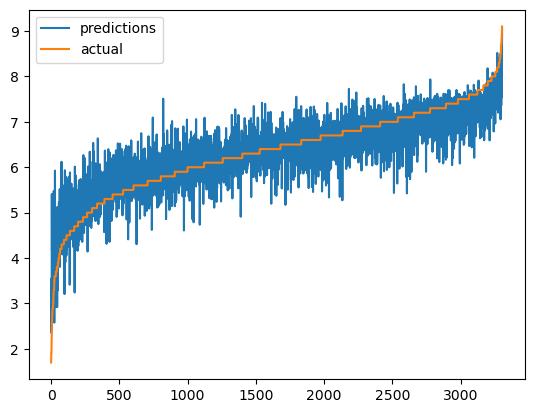

In [9]:
# Create a dataframe for the actual and prediction values
test_compare = pd.DataFrame({'orig_index':y_test_rf.index, 'actual':y_test_rf.values})
test_compare['predictions'] = rating_predictions
test_compare = test_compare.sort_values('actual').reset_index(drop=True)

# Plot the dataframe
test_lines = test_compare[['predictions', 'actual']].plot.line()

## Plot the Training predictions and actuals together

In [10]:
# Check the model against the training data - if mse is much lower than the model is overfitting
y_train_pred = rf_model_rating.predict(X_train_rf)
mse_train = mean_squared_error(y_train_rf, y_train_pred)
mse_train

0.028885164220877464

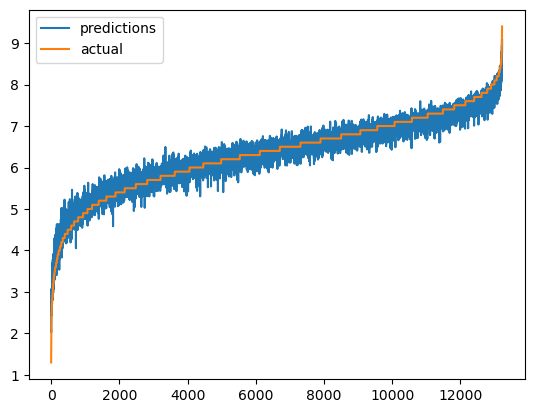

In [11]:
# Create a dataframe for the actual and prediction values
train_compare = pd.DataFrame({'orig_index':y_train_rf.index, 'actual':y_train_rf.values})
train_compare['predictions'] = y_train_pred
train_compare = train_compare.sort_values('actual').reset_index(drop=True)

# Plot the dataframe
train_lines = train_compare[['predictions', 'actual']].plot.line()

# Applying Keras Tuner

## Convert categorical data into dummy columns for Keras Tuner

In [12]:
df_rating = pd.get_dummies(data=df_rating, columns=['genres', 'OMDB_Rated'])
df_rating.head()

,Writer_Avg_Rating,Director_Avg_Rating,Actor_Avg_Rating,runtimeMinutes,OMDB_Metascore,ReleaseMonth,averageRating,genres_Action,genres_Adult,genres_Comedy,...,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Thriller,genres_Unknown,genres_Western,OMDB_Rated_adults,OMDB_Rated_kids,OMDB_Rated_teens,OMDB_Rated_unknown
3,6.86,7.17,6.51,118,44.0,12.0,6.4,0,0,1,...,0,0,0,0,0,0,0,0,1,0
24,5.39,6.88,6.73,122,79.0,11.0,6.7,0,0,0,...,0,0,0,0,0,0,1,0,0,0
219,5.73,5.90,6.04,94,45.0,5.0,5.9,0,0,1,...,0,0,0,0,0,0,0,0,0,1
263,6.40,6.68,5.91,103,60.0,1.0,6.7,0,0,0,...,0,0,0,0,0,0,1,0,0,0
282,6.80,6.93,6.36,116,79.0,11.0,6.9,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## Split the data into training and test sets

In [13]:
# Define features as X, target as y
y = df_rating['averageRating']
X = df_rating.drop(columns='averageRating')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scale the data

In [14]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Define the keras tuner behavior and execute

In [15]:
# Define the keras tuner parameters
def create_model(hp):
    movie_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    # Allow kerastuner to decide which optimizer
    optimizer = hp.Choice('opt', values=['adam', 'sgd', 'rmsprop'])
    
    # Allow kerastuner to decide number of neurons in first layer
    movie_model.add(tf.keras.layers.Dense(units=hp.Int('first_units', min_value=1, max_value=10, step=2), 
                                          activation=activation, input_dim=24))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        movie_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))

    movie_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Compile the model
    movie_model.compile(loss="mse", optimizer=optimizer, metrics=[tf.keras.metrics.MeanSquaredError()])

    return movie_model

In [16]:
tuner = kt.Hyperband(
    create_model,
    objective="val_loss",
    max_epochs=20,
    hyperband_iterations=2, 
    project_name='movie_viewers')

In [17]:
# Grab start time
start_time = time.time()

# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

# Print time taken
print("--- %s minutes ---" % round(((time.time() - start_time)/60),2))

# 181k rows, 22 dimensions = 104 minutes

Trial 60 Complete [00h 00m 34s]
val_loss: 29.397062301635742

Best val_loss So Far: 29.39705467224121
Total elapsed time: 00h 12m 58s
--- 12.96 minutes ---


In [18]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'relu',
 'opt': 'rmsprop',
 'first_units': 9,
 'num_layers': 2,
 'units_0': 3,
 'units_1': 7,
 'units_2': 9,
 'units_3': 1,
 'units_4': 3,
 'units_5': 1,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [19]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, MSE: {model_accuracy}")

104/104 - 0s - loss: 29.3971 - mean_squared_error: 29.3971 - 346ms/epoch - 3ms/step
Loss: 29.39705467224121, MSE: 29.39705467224121


In [20]:
# Check the model against the training data - if mse is much lower than the model is overtraining
model_loss_train, model_accuracy_train = best_model.evaluate(X_train_scaled,y_train,verbose=2)
print(f"Loss: {model_loss_train}, MSE: {model_accuracy_train}")

414/414 - 1s - loss: 29.4675 - mean_squared_error: 29.4675 - 787ms/epoch - 2ms/step
Loss: 29.4675235748291, MSE: 29.4675235748291


In [21]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 225       
                                                                 
 dense_1 (Dense)             (None, 3)                 30        
                                                                 
 dense_2 (Dense)             (None, 7)                 28        
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 291 (1.14 KB)
Trainable params: 291 (1.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Create, Train, and Evaluate a Model based on Keras Tuner Output Using More Epochs

In [22]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=9, activation="relu", input_dim=24))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=3, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=7, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 9)                 225       
                                                                 
 dense_5 (Dense)             (None, 3)                 30        
                                                                 
 dense_6 (Dense)             (None, 7)                 28        
                                                                 
 dense_7 (Dense)             (None, 1)                 8         
                                                                 
Total params: 291 (1.14 KB)
Trainable params: 291 (1.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# Grab start time
start_time = time.time()

# Compile the model 
nn.compile(loss="mse", optimizer="rmsprop", metrics=[tf.keras.metrics.MeanSquaredError()])

# Train the model over 100 epochs
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

# Print time taken
print("--- %s minutes ---" % round(((time.time() - start_time)/60),2))

Epoch 1/100
414/414 [==============================] - 2s 3ms/step - loss: 16.3543 - mean_squared_error: 16.3543
Epoch 2/100
414/414 [==============================] - 1s 2ms/step - loss: 0.5688 - mean_squared_error: 0.5688
Epoch 3/100
414/414 [==============================] - 1s 2ms/step - loss: 0.2912 - mean_squared_error: 0.2912
Epoch 4/100
414/414 [==============================] - 1s 2ms/step - loss: 0.2507 - mean_squared_error: 0.2507
Epoch 5/100
414/414 [==============================] - 1s 3ms/step - loss: 0.2365 - mean_squared_error: 0.2365
Epoch 6/100
414/414 [==============================] - 1s 3ms/step - loss: 0.2295 - mean_squared_error: 0.2295
Epoch 7/100
414/414 [==============================] - 1s 2ms/step - loss: 0.2249 - mean_squared_error: 0.2249
Epoch 8/100
414/414 [==============================] - 1s 3ms/step - loss: 0.2230 - mean_squared_error: 0.2230
Epoch 9/100
414/414 [==============================] - 1s 3ms/step - loss: 0.2199 - mean_squared_error: 0.2199

In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

104/104 - 0s - loss: 0.2299 - mean_squared_error: 0.2299 - 360ms/epoch - 3ms/step
Loss: 0.22991560399532318, Accuracy: 0.22991560399532318


# Export the Random Forest Results

In [25]:
print(f'rf_df_rating length: {len(rf_df_rating)}')
print(f'rf_df_rating columns: {len(rf_df_rating.columns)}')
print(f'test_compare length: {len(test_compare)}')
print(f'test_compare columns: {len(test_compare.columns)}')
print(f'train_compare length: {len(train_compare)}')
print(f'train_compare columns: {len(train_compare.columns)}')

rf_df_rating length: 16525
rf_df_rating columns: 9
test_compare length: 3305
test_compare columns: 3
train_compare length: 13220
train_compare columns: 3


In [26]:
predict_compare = pd.concat([test_compare, train_compare])
print(f'predict_compare length: {len(predict_compare)}')
predict_compare.head(2)

predict_compare length: 16525


,orig_index,actual,predictions
0,112306,1.7,2.363667
1,90042,1.9,2.497333


In [35]:
user_movie_predictions = rf_df_rating.merge(predict_compare, left_on=rf_df_rating.index, right_on='orig_index')
user_movie_predictions = user_movie_predictions.drop(columns='orig_index')
user_movie_predictions

,Writer_Avg_Rating,Director_Avg_Rating,Actor_Avg_Rating,runtimeMinutes,OMDB_Metascore,genres,OMDB_Rated,ReleaseMonth,averageRating,actual,predictions
0,6.86,7.17,6.51,118,44.0,2,2,12.0,6.4,6.4,6.802333
1,5.39,6.88,6.73,122,79.0,4,0,11.0,6.7,6.7,6.843000
2,5.73,5.90,6.04,94,45.0,2,3,5.0,5.9,5.9,5.819333
3,6.40,6.68,5.91,103,60.0,6,0,1.0,6.7,6.7,6.263667
4,6.80,6.93,6.36,116,79.0,2,1,11.0,6.9,6.9,7.011667
...,...,...,...,...,...,...,...,...,...,...,...
16520,6.40,6.40,6.17,91,64.0,2,3,1.0,6.0,6.0,6.380000
16521,7.15,7.15,5.63,101,57.0,2,2,2.0,6.1,6.1,6.369333
16522,5.20,6.50,5.71,88,35.0,2,0,4.0,5.2,5.2,5.341000
16523,6.82,6.63,6.88,97,70.0,4,0,1.0,7.0,7.0,6.921000


In [36]:
user_movie_predictions.to_csv("../Resources/movie_viewers_model_results.csv")